# **Modeling and Evaluation**

## Objectives

* Address the business requirement by delivering a machine learning tool capable of predicting 'eyes open' or 'eyes closed' based on eye images.
* Develop a functional Convolutional Neural Network (CNN) model achieving a prediction accuracy exceeding 90%.

## Inputs

* Use a .pkl file containing the specified image sizes for model fitting.
* Employ the Drowsiness dataset, consisting of .jpg files categorized into three folders.
  * File paths for each folder are as follows:
    - inputs/awareness/test
    - inputs/awareness/train
    - inputs/awareness/validation

## Outputs

* Generate a bar graph showing the distribution of images in the test, train, and validation sets.
* Produce augmented images and create a plot of the images per label.
* Develop a machine learning model.
* Optimize hyperparameter settings using Keras tuner.
* Train the model.
* Save the trained model.
* Create line graphs illustrating the learning curve, depicting accuracy and loss during model training.
* Evaluate the model's performance.
* Generate a confusion matrix.
* Save a .pkl file containing the evaluated model data.
* Perform predictions on a randomly selected image from the dataset.


---

## Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import tensorflow as tf
sns.set_style("white")
from matplotlib.image import imread

2023-12-29 20:15:32.080993: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/PP5-Driver-Awareness-Detector/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/PP5-Driver-Awareness-Detector'

---

##  Set the Input Directories

Assign the input directories to variables to be used

In [5]:
my_data_dir = 'inputs/awareness'

# add extension for each folder
train_data = my_data_dir + '/train' 
validation_data = my_data_dir + '/validation'
test_data = my_data_dir + '/test'

---

##  Set the Output Directories

Assign the path for the output

In [9]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print(f'Version already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Version already available create a new version.


---

##  Set the label names

In [10]:
labels = os.listdir(train_data)
print('Image labels to be used are:', labels)

Image labels to be used are: ['eyes_closed', 'eyes_open']


## Set Image Shape

In [11]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(92, 92, 1)

---

## Number of Images in Train, Validation, and Test Sets

* train - eyes_closed: 16800 images
* train - eyes_open: 16800 images
* validation - eyes_closed: 2400 images
* validation - eyes_open: 2400 images
* test - eyes_closed: 4800 images
* test - eyes_open: 4800 images




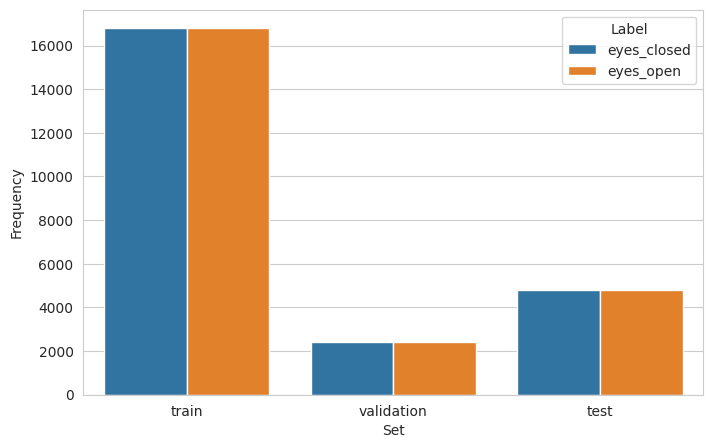

In [12]:
df_freq = pd.DataFrame([]) 

for folder in ['train', 'validation', 'test']:
    for label in labels:
        num_images = len(os.listdir(os.path.join(my_data_dir, folder, label)))
        df_freq = pd.concat([df_freq,
                            pd.DataFrame({'Set': [folder],
                                          'Label': [label],
                                          'Frequency': [num_images]})],
                            ignore_index=True)

        print(f"* {folder} - {label}: {num_images} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

---

# Image Data Augmentation

### Import Image Data Generator

In [13]:
# Import Image data generator from tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Initialize Image Data Generator

In [14]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

### Augment Train Image Dataset

In [22]:
batch_size = 40 # Set batch size
train_set = augmented_image_data.flow_from_directory(train_data,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True
                                              )

train_set.class_indices

Found 33600 images belonging to 2 classes.


{'eyes_closed': 0, 'eyes_open': 1}

### Augment Validation Image Dataset

In [23]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_data,
                                                          target_size=image_shape[:2],
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='binary',
                                                          shuffle=False
                                                          )

validation_set.class_indices

Found 4800 images belonging to 2 classes.


{'eyes_closed': 0, 'eyes_open': 1}

### Augment Test Image Dataset

In [24]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_data,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False
                                                    )

test_set.class_indices

Found 9600 images belonging to 2 classes.


{'eyes_closed': 0, 'eyes_open': 1}

---